# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.hidden_layer_1 = DenseLayer(num_features, n_hidden_1, name='hidden_layer_1')
    self.hidden_layer_2 = DenseLayer(n_hidden_1, n_hidden_2, name='hidden_layer_2')
    self.output_layer = DenseLayer(n_hidden_2, num_classes, name='output_layer')



  def __call__(self, x):
     x = self.hidden_layer_1(x)
     x = self.hidden_layer_2(x)
     x=tf.nn.softmax(self.output_layer(x))
     return x

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    trainable_variables = neural_net.trainable_variables
    gradients= g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss




In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
steps_per_epoch = len(x_train) // batch_size
for step, (batch_x, batch_y) in enumerate(train_data.take(steps_per_epoch * training_steps), 1): # Место для вашего кода:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    loss = train(neural_net, batch_x, batch_y)
    loss_history.append(loss)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Место для вашего кода
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")


Показано результат, скорочений до останніх рядків (5000).
Step: 202100, Loss: 401.7809143066406, Accuracy: 0.87109375
Step: 202200, Loss: 404.4111328125, Accuracy: 0.85546875
Step: 202300, Loss: 396.8227233886719, Accuracy: 0.8984375
Step: 202400, Loss: 403.1632080078125, Accuracy: 0.87890625
Step: 202500, Loss: 403.84454345703125, Accuracy: 0.86328125
Step: 202600, Loss: 402.0785217285156, Accuracy: 0.875
Step: 202700, Loss: 398.26336669921875, Accuracy: 0.890625
Step: 202800, Loss: 399.8960876464844, Accuracy: 0.88671875
Step: 202900, Loss: 402.3232727050781, Accuracy: 0.859375
Step: 203000, Loss: 395.77459716796875, Accuracy: 0.89453125
Step: 203100, Loss: 404.49188232421875, Accuracy: 0.85546875
Step: 203200, Loss: 403.6042785644531, Accuracy: 0.86328125
Step: 203300, Loss: 403.8244323730469, Accuracy: 0.86328125
Step: 203400, Loss: 401.0628662109375, Accuracy: 0.87890625
Step: 203500, Loss: 401.87994384765625, Accuracy: 0.87109375
Step: 203600, Loss: 399.46893310546875, Accuracy: 

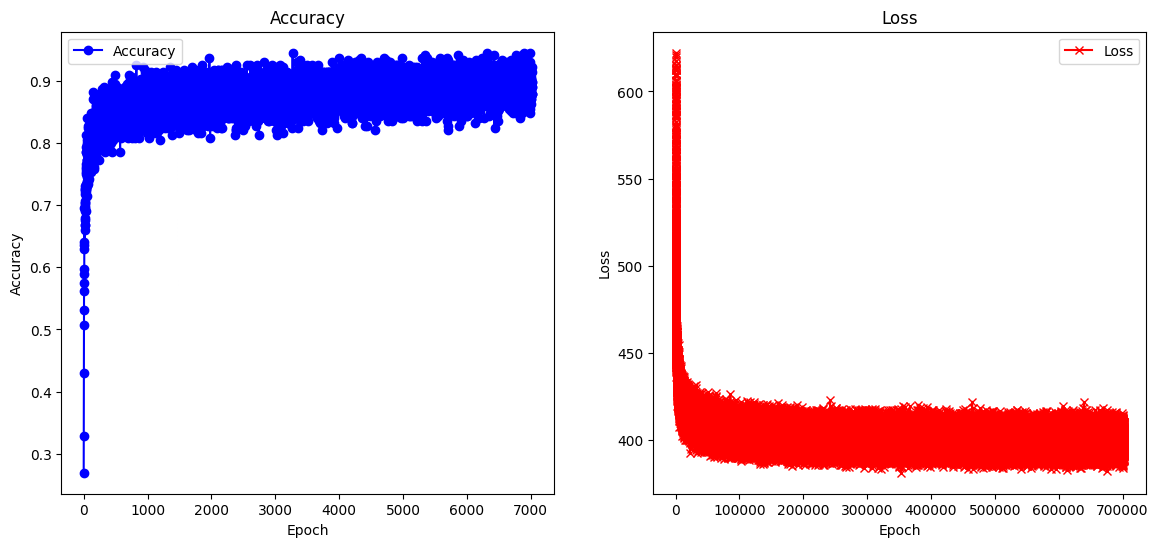

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy
axes[0].plot(accuracy_history, label='Accuracy', color='b', marker='o')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(loss_history, label='Loss', color='r', marker='x')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_title('Loss')
axes[1].legend()


In [10]:
# Обчисліть точність навченої нейромережі
test_accuracy = accuracy(neural_net(x_test), y_test)
print(f"Test Accuracy: {test_accuracy.numpy()}")

Test Accuracy: 0.8729000091552734


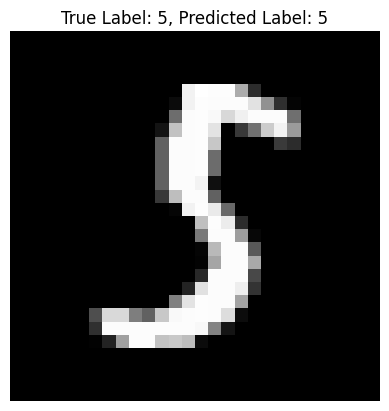

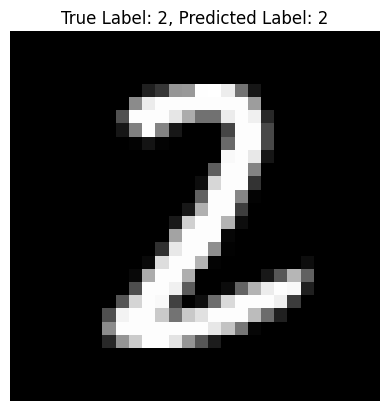

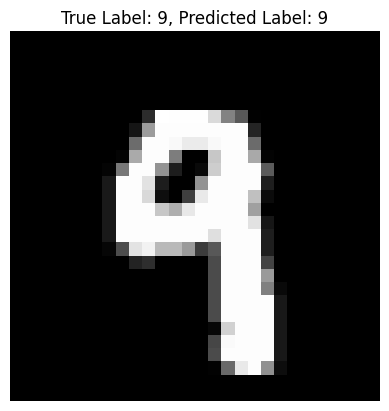

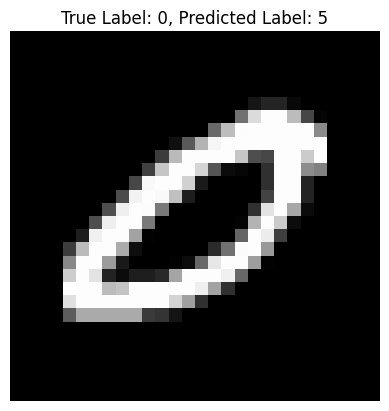

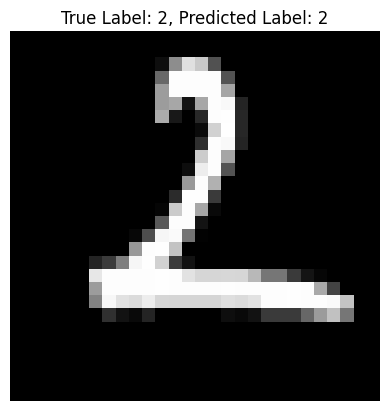

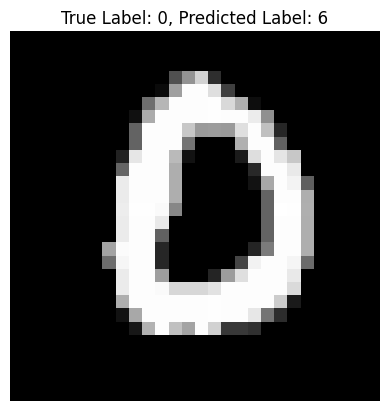

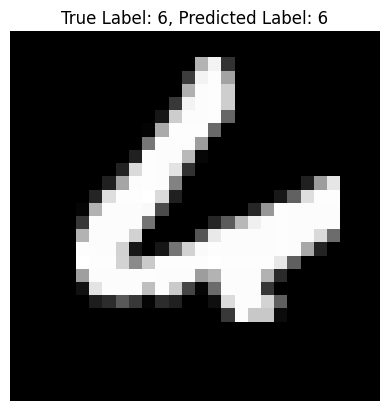

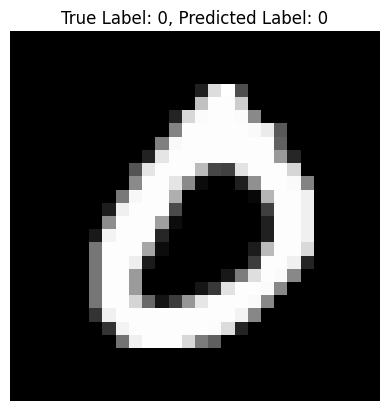

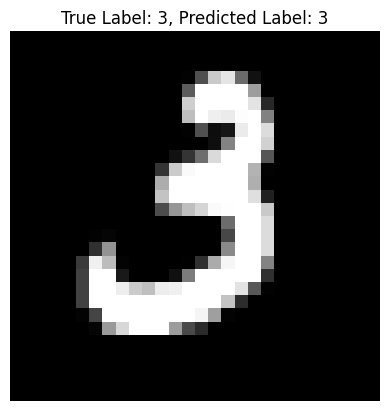

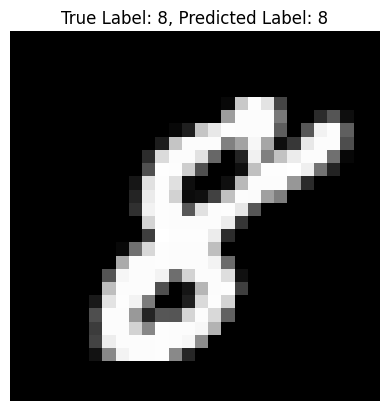

In [11]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?
import random

random.seed(123)
indices = random.sample(range(len(x_test)), 10)

for index in indices:
    test_image = x_test[index]
    test_label = y_test[index]

    pred_probs = neural_net(tf.expand_dims(test_image, axis=0))
    pred_label = tf.argmax(pred_probs, axis=1).numpy()[0]

    plt.imshow(test_image.reshape(28, 28), cmap='gray')
    plt.title(f"True Label: {test_label}, Predicted Label: {pred_label}")
    plt.axis('off')
    plt.show()



**Висновок**
Точність тестування нейромережі становить приблизно 87.29%. Це означає, що мережа вірно класифікує близько 8729.74% тестових зображень, що є хорошим показником.

У цьому тесті було використано 10 рукописних зображень цифр для перевірки роботи нейромережі. З цих 10 зображень усі 10 були правильно визначені. Це говорить про те, що в цьому конкретному тестовому наборі нейромережа показала високу ефективність і точність.

Однак варто зазначити, що результати тестування не завжди повністю відображають роботу нейромережі в реальних умовах. Застосування нейромережі до нових, раніше не бачених даних може призвести до інших результатів, і точність може відрізнятися залежно від складності та різноманітності тестового набору.

Матриця помилок дає змогу наочно побачити, які класи (цифри) було правильно визначено, а які було неправильно класифіковано. Основна діагональ матриці являє собою правильні передбачення, а значення поза діагоналлю вказують на помилки класифікації. Що темніший колір клітинки на тепловій карті, то менше помилок класифікації між відповідними класами. Що світліший колір клітинки, то більше помилок.

Нейромережа найгірше визначає цифру 0, а найкраще цифру 2. Найчастіше плутає 0 з 5 та 0 з 6.

Загалом нейромережа, здатна правильно визначати рукописні цифри може бути корисною в різних додатках, як-от системи оптичного розпізнавання символів (OCR), системи класифікації почерку та інші завдання, пов'язані з опрацюванням рукописних даних.